# **Breast Cancer - Comparative Analysis**

Dataset link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

The following project will focus on finding the architecture with the best metrics (Accuracy, F1 and AUC) for this dataset. The proposed architectures for this experiment are:
* NASNet



This notebook represents one of the three which will run experiments with images where the Magnification factor is 40x.   


## **Setting the Resources** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19553 sha256=2e2116ea39b02dcfbe92d9c75e21c0d1c3365022ab9735cb3011d84237318b0f
  Stored in directory: /root/.cache/pip/wheels/fe/5d/69/ff53a908b9f14fb7730a58fdede0fac4cdc99ef3624ec76d05
Successfully built validators


In [3]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.9 MB/s 


In [4]:
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

import seaborn as sns
import cv2 as cv
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, ZeroPadding2D, Input, Add, BatchNormalization, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import decode_predictions

from vit_keras import vit, utils
import tensorflow_addons as tfa
### 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from imutils import paths
import argparse


The current project will make use of one GPU:

In [ ]:
#!nvidia-smi

## Inspecting the Data 

In [6]:
# setting up the train and test directories

train_dir = '/content/drive/MyDrive/Estudo - DS e ML/Cursos ML Alura /Nova pasta/breakHis_dataset/BreakHis400x_Balanceado/train_set'
val_dir = '/content/drive/MyDrive/Estudo - DS e ML/Cursos ML Alura /Nova pasta/breakHis_dataset/BreakHis400x_Balanceado/validation_set'
test_dir = '/content/drive/MyDrive/Estudo - DS e ML/Cursos ML Alura /Nova pasta/breakHis_dataset/BreakHis400x_Balanceado/test_set'

In [7]:
# Walk through directories
for dirpath, dirnames, filenames in os.walk("datasets/BreakHis400x_Balanceado/train_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("datasets/BreakHis400x_Balanceado/validation_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("datasets/BreakHis400x_Balanceado/test_set//"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Estudo - DS e ML/Cursos ML Alura /Nova pasta/breakHis_dataset/BreakHis400x_Balanceado/train_set')

# creating a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


### Visualizing the Data

In [9]:
# checking the images

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder),1)
   # print(random_image)
    
    # read in the image and plot using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    #print(f'Image shape: {img.shape}')
    
    return img

In [ ]:
#view_random_image(train_dir, 'malignant')

## 2. Preprocess the Data (Prepare it for the experiments)

In [26]:
batch = 32

In [10]:
# Rescale
IMG_SIZE=(224,224)

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
# horizontal_flip=True, vertical_flip=True, rotation_range=90)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# # Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=32,
                                              class_mode='categorical', shuffle=True)

validation_data = validation_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=32,
                                                   class_mode='categorical', shuffle=True)

test_data = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, 
                                             batch_size=32, class_mode='categorical')



Found 1209 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [11]:
num_train = train_data.samples
num_validation = validation_data.samples
num_test = test_data.samples

In [12]:
num_test

180

In [13]:
print (validation_data.class_indices)

{'benign': 0, 'malignant': 1}


## 3. Create a Model 

https://github.com/faustomorales/vit-keras

In [14]:
# Plotting the validation and training curves separately

def plot_loss_curves(history, network):
    """
    Returns separeted loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs did we run for?
    
    plt.figure(figsize=(14,4))
    
    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.suptitle(network, fontsize=14)

## ViT

In [29]:
image_size = 224

# model = vit.vit_l32(
#     image_size=image_size,
#     activation='sigmoid',
#     pretrained=True,
#     include_top=True,
#     pretrained_top=False,
#     classes=2
# )

vit_model = vit.vit_b32(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

In [30]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

In [31]:
num_classes = 2
input_img_size = 224

In [32]:
# Compile
#model = tf.keras.Model(inputs, outputs, name="ViT")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print(model.summary())

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_3 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2)          

## 4. Fit a Model 

In [33]:
# def fitting_model(model):
#     callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, patience=6),
#              keras.callbacks.ModelCheckpoint(filepath='melhor_modelo_nasnet_large_28052022.hdf5', monitor='val_loss', save_best_only=True)]
#     with tf.device('/device:GPU:0'):
#         history = model.fit(train_data, epochs=50, steps_per_epoch=len(train_data), validation_data=validation_data,
#                            validation_steps=len(validation_data))
#     return history

In [34]:
history = model.fit(train_data, epochs=100, 
                    steps_per_epoch=len(train_data), 
                    validation_data=validation_data,
                    validation_steps=len(validation_data))

Epoch 1/100
38/38 [==============================] - 45s 773ms/step - loss: 0.4243 - accuracy: 0.8122 - val_loss: 1.0442 - val_accuracy: 0.5056
Epoch 2/100
38/38 [==============================] - 27s 704ms/step - loss: 0.3557 - accuracy: 0.8437 - val_loss: 1.8169 - val_accuracy: 0.5000
Epoch 3/100
38/38 [==============================] - 27s 694ms/step - loss: 0.3566 - accuracy: 0.8486 - val_loss: 5.9150 - val_accuracy: 0.5000
Epoch 4/100
38/38 [==============================] - 27s 709ms/step - loss: 0.3462 - accuracy: 0.8462 - val_loss: 3.6613 - val_accuracy: 0.5000
Epoch 5/100
38/38 [==============================] - 27s 699ms/step - loss: 0.3296 - accuracy: 0.8561 - val_loss: 0.6745 - val_accuracy: 0.8000
Epoch 6/100
38/38 [==============================] - 27s 696ms/step - loss: 0.3594 - accuracy: 0.8470 - val_loss: 2.9438 - val_accuracy: 0.5000
Epoch 7/100
38/38 [==============================] - 27s 695ms/step - loss: 0.3172 - accuracy: 0.8701 - val_loss: 0.7600 - val_accuracy:

## 5. Evaluate Models 

CPU times: user 29.8 ms, sys: 2.06 ms, total: 31.9 ms
Wall time: 33.8 ms


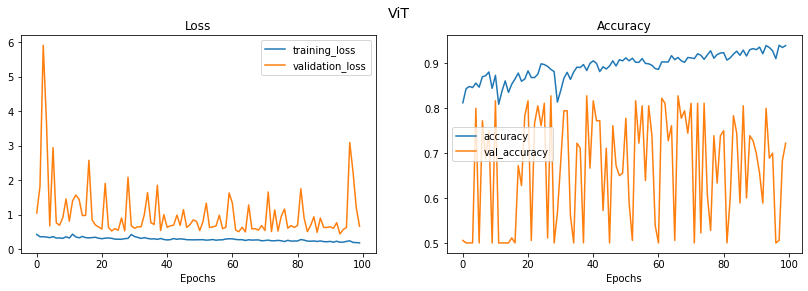

In [35]:
%%time
## NASNet
#model = build_model(num_classes, input_img_size)
#history = fitting_model(model)
#loss, acc = model.evaluate(test_data)
plot_loss_curves(history, "ViT")

**Acc de 82 na validação**

In [36]:
model.save('vit_30052022.h5')

In [37]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

### Matriz de confusão para o conjunto de validação ###
6/6 [==============================] - 5s 461ms/step


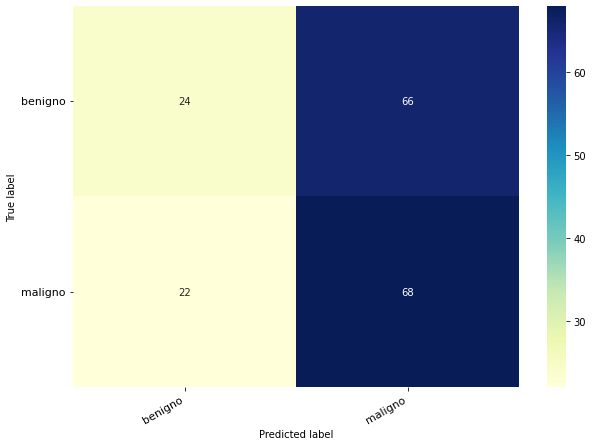

In [38]:
### Conjunto de Validação ###

print ("### Matriz de confusão para o conjunto de validação ###")

#Conjunto de validação

#Confution Matrix
Y_pred = model.predict(validation_data, num_validation//batch, verbose=1)
#y_label = (np.expand_dims(test_generator_eval.classes, axis=1).ravel()).astype(int)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = validation_data.classes
cm = confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["benigno", "maligno"], figsize = (10,7), fontsize=11)

### Matriz de confusão para o conjunto de teste ###
180/180 [==============================] - 3s 13ms/step - loss: 0.6275 - accuracy: 0.7500
Test accuracy: 0.750
Test loss: 0.627


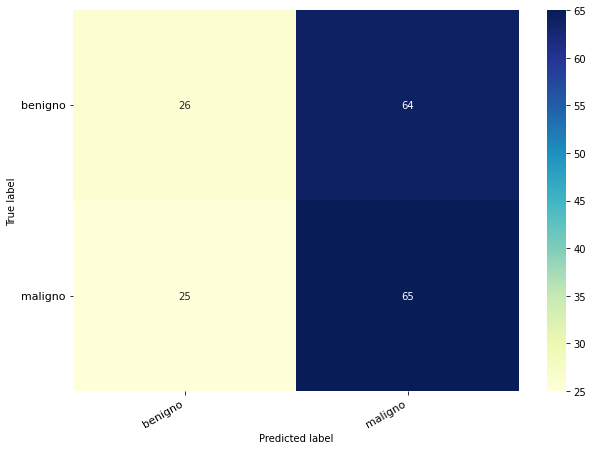

In [39]:
## Conjunto de Teste ###

print ("### Matriz de confusão para o conjunto de teste ###")


#Confution Matrix
Y_pred = model.predict(test_data, num_test, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = test_data.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["benigno", "maligno"], figsize = (10,7), fontsize=11)

# Accuracy and Loss for the Test set
loss, acc = model.evaluate_generator(test_data, num_test, verbose=1)

# Final accuracy and loss
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

## Implementing Grad-CAM to the Model

Grad-Cam, unlike CAM, uses the gradient information flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest.

In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
nasnet = keras.models.load_model('nasnet_balanced_no_DA_26052022.h5')

In [ ]:
#nasnet.summary()

In [ ]:
img_size = (224, 224)

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    
    return array

In [ ]:
#model_builder = tf.keras.applications.nasnet.NASNetLarge
img_size = (224, 224)
preprocess_input = tf.keras.applications.nasnet.preprocess_input
decode_predictions = tf.keras.applications.nasnet.decode_predictions

last_conv_layer_name = list(filter(lambda x: isinstance(x,keras.layers.Conv2D), 
                                                          nasnet.layers))[-1].name
print(last_conv_layer_name)
# The local path to our target image

#img_array = get_img_array('datasets/brecahad_test_set/Case_16-10.png', 224)

normal_conv_1_18


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    #grad_model.summary()

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## Select sample

In [ ]:
case = "Case_7-01"

1/1 [==============================] - 0s 197ms/step
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
benign
Predicted: [9.9999988e-01 1.2663509e-07]


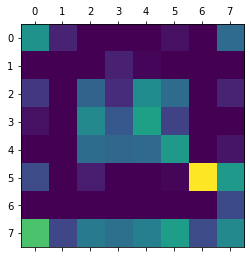

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array('datasets/brecahad_test_set/'+case+'.png', size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
#nasnet.layers[-1].activation = None
# Print what the top predicted class is
#preds = (nasnet.predict(img_array) > 0.5).astype("int32")
preds = nasnet.predict(img_array)
model_preds = tf.squeeze(tf.round(preds))
print(model_preds)
top_pred_index = tf.argmax(preds[0])
print(top_pred_index)
print(class_names[top_pred_index])
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, nasnet, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
plt.figure(figsize=(16,12))

def save_and_display_gradcam(img_path, heatmap, cam_path="datasets/brecahad_test_set_gradcam/"+case+".png", alpha=0.8):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path, width=350, height=350))
    return plt.imshow(superimposed_img)

#save_and_display_gradcam('datasets/brecahad_test_set/'+case+'.png', heatmap)

<Figure size 1152x864 with 0 Axes>

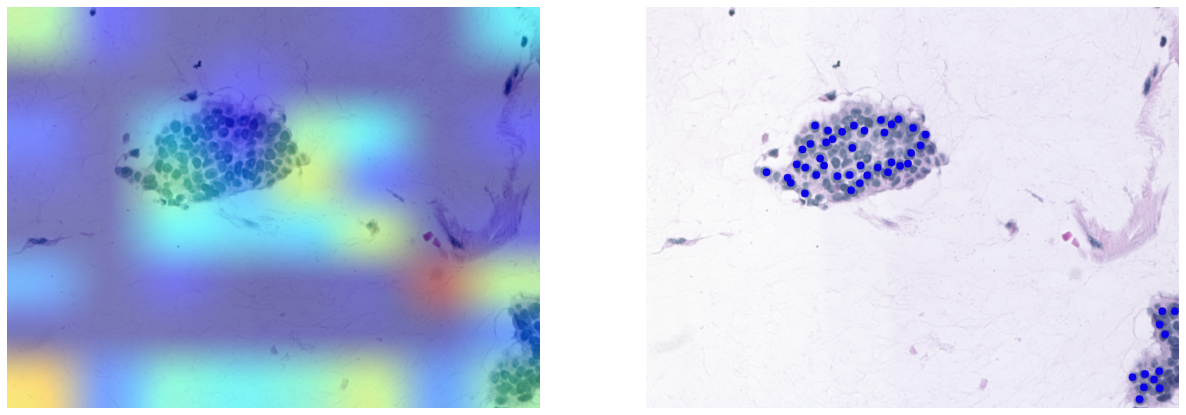

In [ ]:
IMG = 'datasets/brecahad_test_set/'+case+'.png'
PATH = 'datasets/brecahad_test_set/'+case+'.png'
plt.figure(figsize=(21,10))
PATH2 = 'datasets/groundTruth_display/'+case+'.png'
img = tf.keras.utils.load_img(PATH2)
img_orig = tf.keras.utils.load_img(PATH)

#plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.axis(False)
save_and_display_gradcam(img_path=IMG, heatmap=heatmap)
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(img)
# plt.subplot(1,3,3)
# plt.axis(False)
# plt.imshow(img_orig)